In [23]:
#패키지 불러오기
import cv2
import numpy as np
import os
from random import shuffle
from tqdm import tqdm

#데이터 경로 설정
TRAIN_DIR = 'D:/data/train'
TEST_DIR = 'D:/data/test'

#이미지 크기 변환
IMG_SIZE = 50

#Learning Rate
LR = 1e-3


MODEL_NAME = 'knifevsother{}-{}.model'.format(LR, '2conv-basic')

In [39]:
#이미지 라벨링
def label_img(img):
    word_label = img.split('.')[-3]
    
    if word_label == 'knife' : return[1,0]
    elif word_label == 'other':return[0,1]

In [25]:
def create_train_data():
    training_data = []
    
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR, img)
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img), np.array(label)])
        
    shuffle(training_data)
    
    np.save('train_data.npy', training_data)
    
    return training_data

In [26]:
def process_test_data():
    testing_data = []
    
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR, img)
        img_num = img.split('.')[0]
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img), img_num])
        
    shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    
    return testing_data

In [40]:
train_data = create_train_data()
test_data = process_test_data()

 49%|█████████████████▎                 | 8868/17933 [12:13<1:24:39,  1.78it/s]

KeyboardInterrupt: 

In [28]:
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression

In [29]:
convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 128, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 2, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')


train = train_data[:-500]
test = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

In [30]:
model.fit({'input': X}, {'targets': Y}, n_epoch=3, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 818  | total loss: 0.24700 | time: 84.233s
| Adam | epoch: 003 | loss: 0.24700 - acc: 0.8925 -- iter: 17408/17433
Training Step: 819  | total loss: 0.24111 | time: 85.580s
| Adam | epoch: 003 | loss: 0.24111 - acc: 0.8939 | val_loss: 0.23305 - val_acc: 0.9060 -- iter: 17433/17433
--


In [31]:
import tensorflow as tf
tf.reset_default_graph()

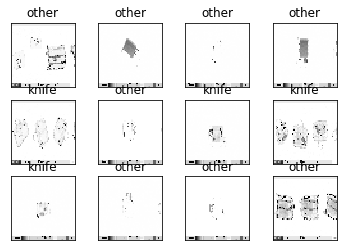

In [41]:
import matplotlib.pyplot as plt

fig=plt.figure()

for num,data in enumerate(test_data[:12]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: str_label='other'
    else: str_label='knife'
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [33]:
with open('b_file.csv','w') as f:
    f.write('id,label\n')
            
with open('b_file.csv','a') as f:
    for data in tqdm(test_data):
        img_num = data[1]
        img_data = data[0]
        orig = img_data
        data = img_data.reshape(IMG_SIZE,IMG_SIZE,1)
        model_out = model.predict([data])[0]
        f.write('{},{}\n'.format(img_num,model_out[1]))

100%|█████████████████████████████████████| 8000/8000 [00:25<00:00, 312.67it/s]
